In [7]:
%matplotlib inline  
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
sns.set(style="white", context="talk")
# sns.set_style('white')

# from bokeh.plotting import figure,show,output_notebook
from bokeh.charts import Bar, output_notebook, show,Histogram,hplot,Line
from bokeh import plotting
plotting.output_notebook()
output_notebook()

Loading BokehJS ...

Loading BokehJS ...

In [5]:
client = pymongo.MongoClient(host='127.0.0.1', port=27017)

db_name = 'esi'
doc_name = 'test'
db = client[db_name]
papers_collection = db['test']
abstract_rank_collection = db['AR3']

In [6]:
pipeline = [
{'$unwind':"$authors"},
{'$group':
    {
        '_id':{'_id':'$_id','citations':'$citations','wos_no':'$wos_no'},
        'author_count':{'$sum':1},
        }
},
{'$group':
    {
        '_id':'$author_count',
        'paper_count':{'$sum':1},
        'citations_all':{'$sum':'$_id.citations'},
        'citations_avg':{'$avg':'$_id.citations'}
    }
},
{'$project':
    {
        'author_count':"$_id",
        '_id':0,
        'paper_count':1,
        'citations_avg':1

    }
    
},
{'$sort':{'author_count':1}}
]
pp = pd.DataFrame(list(papers_collection.aggregate(pipeline)))
pp.loc[:,['author_count','paper_count']]
pp.loc[:,['author_count','citations_avg']]

author_count  citations_avg
0             1     185.018587
1             2     140.275946
2             3     128.819048
3             4     117.015723
4             5      96.083990
5             6     137.820652
6             7     114.955752
7             8     109.283333
8             9     200.421053
9            10     218.327869


### c1
绝大部分论文是在2～5个人内
### c2
几乎和c1是相反的，
个人完成的论文被引用数排在第3，能力极强的个人
9，10人合作的被引用数排在第2，1，多机构合作，资源更丰富，发表后，更容易被涉及的机构引用
参与人数3，4，5的明显划水更多（主动，被动）


In [10]:
# p = Histogram(pp.loc[:,['author_count','paper_count']],values='paper_count',label='author_count')
p = Bar(pp)
p1 = Bar(pp, label='author_count', values='paper_count',
        title=u"作者数量－论文数量")
p2 = Bar(pp, label='author_count', values='citations_avg',
        title=u"作者数量-每篇论文被引用数")
# p3 = Bar(pp, label='author_count', values='citations_avg',agg='mean',
#         title=u"作者数量-每篇论文被引用数")
# p4 = Bar(pp, label='author_count', values='citations_avg',agg='avg',
#         title=u"作者数量-每篇论文被引用数") not support allowed values are sum, mean, count, nunique, median, min or max
show(p1)
show(p2)

# show(p3)
# show(p4)

In [11]:
pipeline = [
{'$unwind': '$cleaned_keywords'}
,{'$match': {
        'pub_year': {'$in':[2013,2014,2015]}
    }
}
, {
    '$group': {
        '_id': {'keywords': '$cleaned_keywords'},
        'paper_count': {'$sum': 1},
    }
}
, {'$sort': {'paper_count': -1}}
,{'$project':{
        '_id':0,
        'keywords':'$_id.keywords',
    }
   }
,{'$limit':30}
]
keyword_30_docs = list(papers_collection.aggregate(pipeline))
keyword_30 = list(i.get('keywords') for i in keyword_30_docs)
print keyword_30 # 关键字列表，[u'system',u'model',...]
# print keyword_30_docs


[u'system', u'model', u'algorithm', u'network', u'information', u'design', u'optimization', u'classification', u'framework', u'performance', u'selection', u'prediction', u'management', u'neural-network', u'capacity', u'set', u'channel', u'environment', u'approximation', u'genetic algorithm', u'particle swarm optimization', u'identification', u'wireless network', u'global optimization', u'preference relation', u'support vector machine', u'differential evolution', u'transmission', u'simulation', u'web']


In [70]:

pipeline = [
{'$unwind': '$cleaned_keywords'}
, {'$match': {
        'cleaned_keywords': {'$in':keyword_30}
    }
}
,{'$group': {
        '_id': {'keywords': '$cleaned_keywords','pub_year':'$pub_year'},
        'paper_count': {'$sum': 1},
    }
}
,{'$project':{
    'keywords':'$_id.keywords',
    'paper_count':1,
    'pub_year':'$_id.pub_year',
    '_id':0
        }
 }
,{
    '$group': {
        '_id': {'keywords': '$keywords'},
        'year_citations':{'$addToSet':'$$ROOT'}
    }
}
]
keyword_30_yearly = list(papers_collection.aggregate(pipeline))
# print(keyword_30_yearly)
cleaned_k_30 = list(i.get('_id').get('keywords') for i in keyword_30_yearly)
# print(keyword_30_yearly[0])
# print(cleaned_k_30)  # 关键字列表，[u'system',u'model',...]
year_citations = list(i.get('year_citations') for i in keyword_30_yearly)
# yc0 = year_citations[0]
print year_citations[0][0].get('pub_year')
print year_citations[0][0].get('paper_count')
data = []# result
for yc in year_citations:
    d = {}
    for i in yc:
        year = int(i.get('pub_year'))
        paper_count = i.get('paper_count')
        d.update({year:paper_count})
#     print d
    item = {}
    item['keywords'] = yc[0].get('keywords')
    item['year_citations'] = d
    data.append(item)

print data
# for data in year_citations:
#     print data

2005
12
[{'keywords': u'information', 'year_citations': {2005: 12, 2006: 13, 2007: 9, 2008: 11, 2009: 14, 2010: 8, 2011: 11, 2012: 10, 2013: 16, 2014: 27, 2015: 15}}, {'keywords': u'performance', 'year_citations': {2005: 13, 2006: 11, 2007: 8, 2008: 4, 2009: 6, 2010: 7, 2011: 7, 2012: 9, 2013: 13, 2014: 8, 2015: 10}}, {'keywords': u'network', 'year_citations': {2005: 19, 2006: 12, 2007: 10, 2008: 7, 2009: 10, 2010: 13, 2011: 9, 2012: 13, 2013: 22, 2014: 19, 2015: 17}}, {'keywords': u'genetic algorithm', 'year_citations': {2005: 5, 2006: 7, 2007: 2, 2008: 5, 2009: 8, 2010: 6, 2011: 10, 2012: 10, 2013: 13, 2014: 4, 2015: 7}}, {'keywords': u'design', 'year_citations': {2005: 15, 2006: 12, 2007: 10, 2008: 6, 2009: 10, 2010: 6, 2011: 11, 2012: 17, 2013: 20, 2014: 15, 2015: 19}}, {'keywords': u'set', 'year_citations': {2005: 5, 2006: 1, 2007: 1, 2008: 2, 2009: 4, 2010: 3, 2011: 4, 2012: 11, 2013: 6, 2014: 13, 2015: 6}}, {'keywords': u'selection', 'year_citations': {2005: 2, 2006: 2, 2007: 4,

In [78]:
xyvalues = np.array([[2, 3, 7, 5, 26], [12, 33, 47, 15, 126], [22, 43, 10, 25, 26]])

line = Line(data=xyvalues, x=['2012','2013','2014','2015','2016'],title="line", legend="top_left", ylabel='Languages')

show(line)

TypeError: unhashable type: 'PropertyValueList'

In [85]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()
p = figure(plot_width=400, plot_height=400)

# add a line renderer
p.line([2012, 2013, 2014, 2015, 2016], [[6, 7, 2, 4, 5],[7, 2, 4, 6, 5]], line_width=2)

show(p)

Loading BokehJS ...

ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: 0af4dc06-2b98-4834-9d96-5e00a3fc5804
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: d3d4d243-15e3-48fc-b9e2-b7a27fdb703b
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: d9a2f917-8bca-4c70-9250-2b56e32b7e34
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: e1a9c814-cf87-4080-aaf3-9baabc1b72d8
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/co

In [103]:
# colors_list = ['blue', 'yellow']
legends_list = ['first', 'second']
xs= [[1,2,3] for i in range(10)]
ys=[[6, 5, 2], [4, 5, 7]]
p = figure(plot_width=300, plot_height=300)
for (leg, x, y ) in zip(legends_list, xs, ys):
    print 1
    my_plot = p.line(x, y,legend= leg)

show(p)

1
1


ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: 0af4dc06-2b98-4834-9d96-5e00a3fc5804
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: d3d4d243-15e3-48fc-b9e2-b7a27fdb703b
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: d9a2f917-8bca-4c70-9250-2b56e32b7e34
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: e1a9c814-cf87-4080-aaf3-9baabc1b72d8
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/co

In [92]:
from bokeh.plotting import figure, output_notebook, show

p = figure(plot_width=300, plot_height=300,x_range=['2012','2013','2014'])
p.multi_line(
#     xs=[[1, 2, 3], [1, 3, 4]], 
    ys=[[6, 7, 2], [4, 5, 7]],
             color=['red','green'])

show(p)

ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: 0af4dc06-2b98-4834-9d96-5e00a3fc5804
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: d3d4d243-15e3-48fc-b9e2-b7a27fdb703b
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: d9a2f917-8bca-4c70-9250-2b56e32b7e34
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/core/validation/check.pyc:W-1001 (NO_DATA_RENDERERS): Plot has no data renderers: Figure, ViewModel:Plot, ref _id: e1a9c814-cf87-4080-aaf3-9baabc1b72d8
ERROR:/Users/youzipi/.pyenv/versions/2.7.11/lib/python2.7/site-packages/bokeh/co

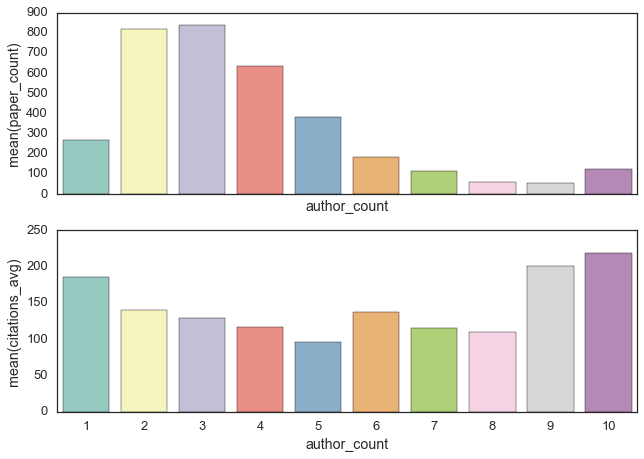

In [75]:
f,(ax1,ax2) = plt.subplots(2,1,sharex=True)
sns.barplot(x=pp['author_count'],y=pp['paper_count'],palette='Set3',ax=ax1)
sns.barplot(x=pp['author_count'],y=pp['citations_avg'],palette='Set3',ax=ax2)

In [41]:
x = np.random.randn(100)
x

array([ 1.29588022,  0.55640805,  0.8532807 ,  0.47724187, -1.27593497,
       -0.24581899,  0.00928686,  0.46340985,  1.55783352,  0.14725645,
       -1.94380153,  1.67250833, -1.2791082 ,  0.1243657 ,  1.07763534,
       -0.98656604, -0.8462655 , -0.58706673, -1.49700659, -1.53218589,
       -1.00481598, -0.89241147, -0.21738262, -0.87088447, -0.18427497,
        0.9172956 ,  1.03693853,  0.4147817 , -0.66014404,  0.431069  ,
        0.30800061,  2.13730529, -0.00916592,  1.09482   , -1.09056988,
        0.04845615, -1.12532939,  0.1624761 ,  0.19138913,  0.49869358,
       -1.04389023,  0.97584069,  0.20979173,  2.06886998,  1.45729616,
        0.13373537, -0.07144427,  1.69671693, -0.16990881, -0.08516404,
        0.00637213,  1.15851986,  0.38511986, -0.75434642,  0.39301418,
       -0.77973927,  0.58616734, -0.50082471, -0.180655  , -0.36097605,
        0.37786711,  0.54440035,  0.95633193,  0.55150771,  0.45454242,
        0.74624879, -0.5153026 , -0.88631954,  0.49856173,  1.89

In [74]:
import numpy as np

# (dict, OrderedDict, lists, arrays and DataFrames are valid inputs)
# data = dict(
#     python=[2, 3, 7, 5, 26, 221, 44, 233, 254, 265, 266, 267, 120, 111],
#     pypy=[1:12, 2:33, 3:47, 4:15, 5:126, 6:121, 7:144, 233, 254, 225, 226, 267, 110, 130],
#     'pypy'=[
#         2005=12,
#         2006:11,
#         2007:17
# #     ]
#     jython=[22, 43, 10, 25, 26, 101, 114, 203, 194, 215, 201, 227, 139, 160],
# )
# data = {kk=2: 12, 3: 14}}
p = figure()
line = p.line(x=[1,2,3,4,5],y=[5,4,3,2,1])

show(line)

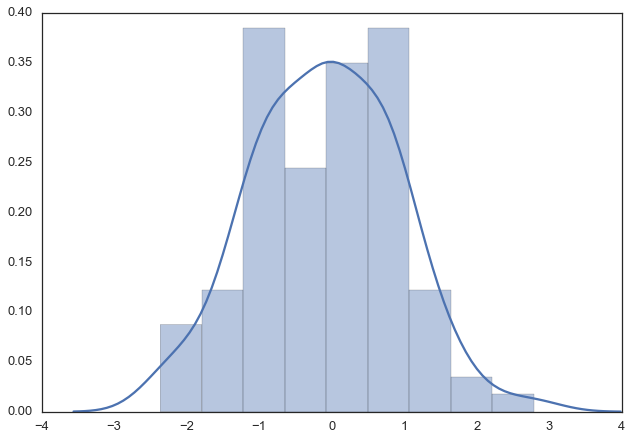

In [40]:
ax = sns.distplot(x)

In [20]:
docs_all = abstract_rank_collection.find()
docs_count = abstract_rank_collection.find().count()
count_all = 0
for i in docs_all:
    count_all += i['count']
print count_all
print docs_count
print count_all/docs_count
docs_count_20 = docs_count*0.2
print docs_count_20

317216
19171
16
3834.2


In [11]:
papers = papers_collection.find(projection=['citations','authors']).sort('citations',pymongo.DESCENDING).limit(10)
papers

In [12]:
for i in papers:
    print i

{u'citations': 10857, u'_id': ObjectId('570cc77cc3666e80eec82f77'), u'authors': [u'Larkin, MA', u'Blackshields, G', u'Brown, NP', u'Chenna, R', u'McGettigan, PA', u'McWilliam, H', u'Valentin, F', u'Wallace, IM', u'Wilm, A', u'Lopez, R']}
{u'citations': 8437, u'_id': ObjectId('570cc77cc3666e80eec82f74'), u'authors': [u'Excoffier, L', u'Laval, G', u'Schneider, S']}
{u'citations': 7957, u'_id': ObjectId('570ccb3ac3666e816e7f8586'), u'authors': [u'Barrett, JC', u'Fry, B', u'Maller, J', u'Daly, MJ']}
{u'citations': 6157, u'_id': ObjectId('570ccb2ec3666e816e7f8575'), u'authors': [u'Stamatakis, A']}
{u'citations': 5053, u'_id': ObjectId('570ccb2dc3666e816e7f8574'), u'authors': [u'Li, H', u'Handsaker, B', u'Wysoker, A', u'Fennell, T', u'Ruan, J', u'Homer, N', u'Marth, G', u'Abecasis, G', u'Durbin, R']}
{u'citations': 4799, u'_id': ObjectId('570cb137c3666e7c2a0f11b2'), u'authors': [u'Li, H', u'Durbin, R']}
{u'citations': 4458, u'_id': ObjectId('570cb135c3666e7c2a0f11b1'), u'authors': [u'Librado

In [13]:
top_count = abstract_rank_collection.find().sort('count', pymongo.DESCENDING).limit(1)[0]['count']
print top_count

2973


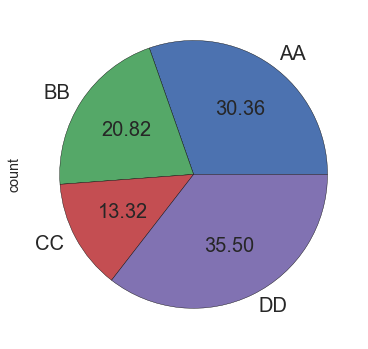

In [15]:
series = pd.Series(3 * np.random.rand(4), index=['a', 'b', 'c', 'd'], name='count')
# series.plot.pie(figsize=(6, 6))
series.plot.pie(labels=['AA', 'BB', 'CC', 'DD'],autopct='%.2f', fontsize=20, figsize=(6, 6))

In [16]:
docs_20 = abstract_rank_collection.find().sort('count', pymongo.DESCENDING).limit(20)
docs_20_percent = abstract_rank_collection.find().sort('count', pymongo.DESCENDING).limit(int(docs_count_20))

count_20 = 0
for i in docs_20_percent:
    count_20 += i['count']
print count_20
print count_20/float(count_all)

285499
0.90001450116


In [17]:
abstract_rank = pd.DataFrame(list(docs))

NameError: name 'docs' is not defined

In [36]:
abstract_rank

_id  count
0      method   2973
1        used   2884
2        data   2835
3     network   2750
4       model   2658
5      result   2449
6   algorithm   2404
7     problem   2114
8     propose   2060
9      system   1918
10      paper   1755
11       base   1652
12    analysi   1600
13    provide   1530
14       show   1456
15   approach   1428
16        set   1343
17    present   1320
18        new   1319
19       also   1281

In [2]:
g = sns.factorplot(x="_id", y="count", data=abstract_rank,
                   size=20, kind="bar", palette="muted")

NameError: name 'sns' is not defined